Downloading the DermanMNIST dataset

In [1]:
!pip install medmnist
from medmnist import DermaMNIST
dataset_train = DermaMNIST(split="train", download=True)
dataset_validate = DermaMNIST(split="val", download=True)
dataset_test = DermaMNIST(split="test", download=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=117485e9c23ff4b83465cafbeb3eeaad2bce53634a04deabbe51ce269e4a5819
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


100%|██████████| 19725078/19725078 [01:34<00:00, 209281.02it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


Importing the required libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import shutil
import skimage
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from keras import backend as K
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer,InputSpec,concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

Shape of the original images

In [3]:
x_train, y_train = dataset_train.imgs, dataset_train.labels
x_test, y_test = dataset_test.imgs, dataset_test.labels
x_val, y_val = dataset_validate.imgs, dataset_validate.labels

print(x_train.shape, y_train.shape, x_train[0].shape)
print(x_test.shape, y_test.shape, x_train[0].shape)
print(x_val.shape, y_val.shape, x_train[0].shape)

(7007, 28, 28, 3) (7007, 1) (28, 28, 3)
(2005, 28, 28, 3) (2005, 1) (28, 28, 3)
(1003, 28, 28, 3) (1003, 1) (28, 28, 3)


Preprocessing the images

In [4]:
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        resized_image = cv2.resize(image, (192, 192))
        preprocessed_images = resized_image
    return np.array(preprocessed_images)

In [5]:
# Convert the labels to 3D tensors
y_train = tf.expand_dims(y_train, -1)
resize_x_train = tf.image.resize(x_train, (192, 192))
resize_y_train = tf.image.resize(y_train, (192, 192))
print(y_train.shape)
print(resize_x_train.shape,resize_y_train.shape)

(7007, 1, 1)
(7007, 192, 192, 3) (192, 192, 1)


In [6]:
# Convert the labels to 3D tensors
y_val = tf.expand_dims(y_val, -1)
resize_x_val = tf.image.resize(x_val, (192, 192))
resize_y_val = tf.image.resize(y_val, (192, 192))
print(y_val.shape)
print(resize_x_val.shape,resize_y_val.shape)

(1003, 1, 1)
(1003, 192, 192, 3) (192, 192, 1)


In [7]:
# Convert the labels to 3D tensors
y_test = tf.expand_dims(y_test, -1)
resize_x_test = tf.image.resize(x_test, (192, 192))
resize_y_test = tf.image.resize(y_test, (192, 192))
print(y_test.shape)
print(resize_x_test.shape,resize_y_test.shape)

(2005, 1, 1)
(2005, 192, 192, 3) (192, 192, 1)


In [8]:
input_shape = (192,192,3)
input_layer = Input(shape=input_shape)

Preparing the base model - InceptionV3

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in inceptionv3_base_model.layers:
    layer.trainable = True
    
x = inceptionv3_base_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputinceptionv3 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inceptionv3 = Model(inputs=input_layer, outputs=outputinceptionv3)

Model Architecture diagram

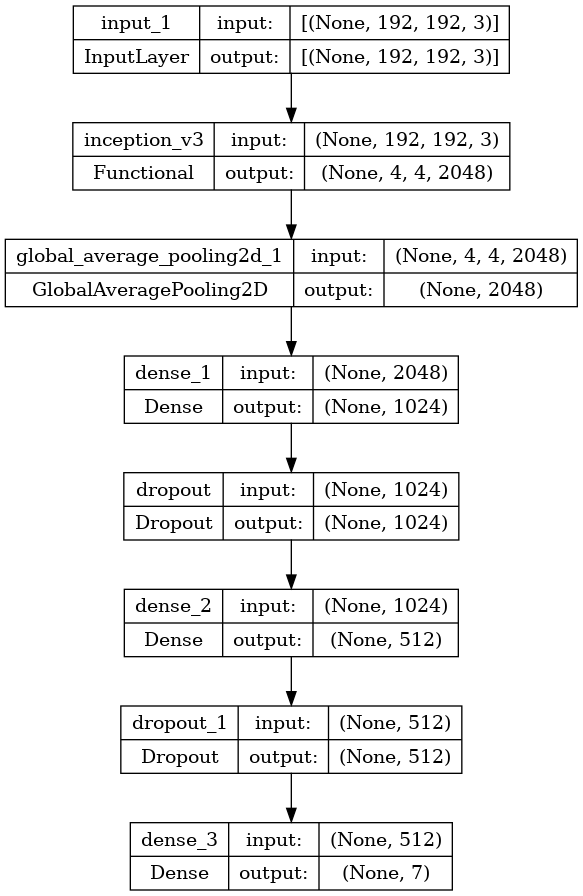

In [20]:
from tensorflow.keras.utils import plot_model
image_path = 'model_architecture_inceptionv3.png'
plot_model(model_inceptionv3, to_file=image_path, show_shapes=True, show_layer_names=True)

Compile Model and Callbacks

In [21]:
# Compile the model
model_inceptionv3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implement learning rate scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

Fitting the data

In [22]:
history_inceptionv3 = model_inceptionv3.fit(
    resize_x_train,
    y_train,
    epochs=100,
    validation_data=(resize_x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
219/219 [==============================] - 62s 130ms/step - loss: 0.9840 - accuracy: 0.6742 - val_loss: 1.0120 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 27s 123ms/step - loss: 0.8296 - accuracy: 0.7039 - val_loss: 0.9221 - val_accuracy: 0.7198 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 27s 122ms/step - loss: 0.8057 - accuracy: 0.7141 - val_loss: 0.9425 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 27s 122ms/step - loss: 0.8075 - accuracy: 0.7141 - val_loss: 1.4590 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 27s 123ms/step - loss: 0.8251 - accuracy: 0.7056 - val_loss: 0.7905 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 27s 122ms/step - loss: 0.7888 - accuracy: 0.7156 - val_loss: 1.0405 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 7/100
219/219 [=========================

Saving the model

In [23]:
model_inceptionv3.save('DermaMNIST_InceptionV3.h5')

Loss - Accuracy Graph

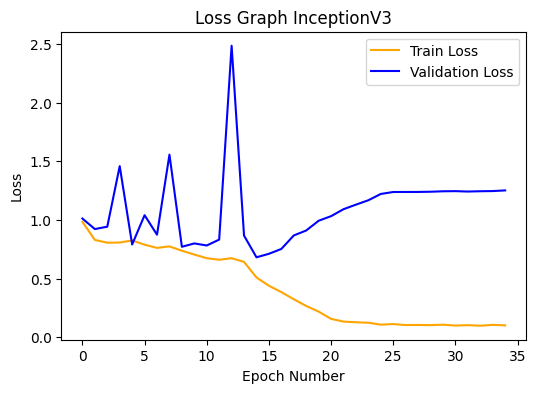

In [24]:
plt.subplots(figsize=(6,4))
plt.plot(history_inceptionv3.epoch, history_inceptionv3.history["loss"], color="orange", label="Train Loss")
plt.plot(history_inceptionv3.epoch, history_inceptionv3.history["val_loss"], color="blue",
label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph InceptionV3")
plt.show()

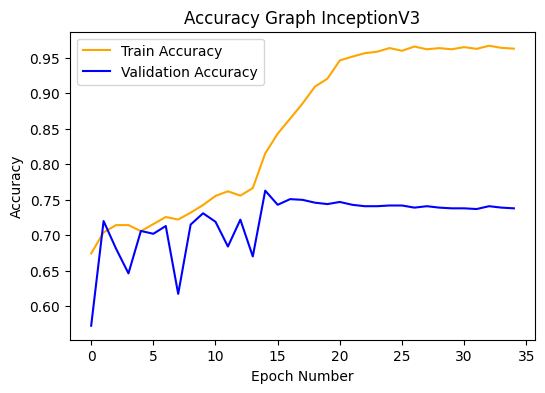

In [25]:
plt.subplots(figsize=(6,4))
plt.plot(history_inceptionv3.epoch, history_inceptionv3.history["accuracy"], color="orange",
label="Train Accuracy")
plt.plot(history_inceptionv3.epoch, history_inceptionv3.history["val_accuracy"], color="blue",
label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph InceptionV3")
plt.show()

Evaluating the model's performance

In [26]:
model_inceptionv3.evaluate(resize_x_test, y_test)

63/63 [==============================] - 2s 39ms/step - loss: 0.6536 - accuracy: 0.7766


[0.6536074280738831, 0.7765585780143738]